In [42]:
import math as m
import numpy as np
import pandas as pd
import scipy.optimize
import statsmodels.tools.numdiff as smnd
import emcee
import itertools

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline

%matplotlib inline

a) 

Model 1 describes the exponential distribution. Microtubulin catastrophe can be categorized as a Poisson process and the waiting time for catastrophe or waiting time for an arrival of a Poisson process is exponentially distributed. $\tau$ = $\frac{1}{r}$ and should be in units of time (seconds) where r is the average rate of microtubulin catastrophe.

Model 2 describes the gamma distribution. It describes the amount of time we have to wait for a certain number of arrivals of a Poisson process, so in this case, describing the amount of time we have to wait for a certain number of microtubulin catastrophes. $a$ is the number of arrivals/ microtubulin catastrophes and $\tau$ = $\frac{1}{r}$ where r is the rate of microtubulin catastrophes. 

Model 3 describes the Weibull distribution. The Weibull distribution serves as a model for aging. In this case, it follows the logic of: the longer we wait for microtubulin to undergo catastrophe, the more likely it will happen. $\beta$ is the shape parameter. For $\beta$ $>$ 1, the longer we have waited, the more likely it is to come, and vice versa for $\beta$ $<$ 1. $\tau$ is the scale parameter, which dictates the rate of catastrophe.

In [43]:
path = "../data/gardner_mt_catastrophe_only_tubulin.csv"
df = pd.read_csv(path, comment='#')

In [44]:
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35.0,25.0,50.0,60.0
1,40.000,45.0,40.0,60.0,75.0
2,40.000,50.0,40.0,60.0,75.0
3,45.429,50.0,45.0,75.0,85.0
4,50.000,55.0,50.0,75.0,115.0


In [45]:
df_new1 = df['12 uM']
df_new1.head()

0    25.000
1    40.000
2    40.000
3    45.429
4    50.000
Name: 12 uM, dtype: float64

In [60]:
def log_likelihood_m1(p, d):
    """
    Log likelihood for model 1
    """
    tau = p[0]
    sum1 = 0
    for i in d:
        sum1 += m.exp(-i/tau) / tau
    return sum1

def log_likelihood_m2(p, f):
    """
    Log likelihood for model 2
    """
    tau = p[0]
    a = p[1]
    sum1 = 0
    for d in f:
        sum1 += (d/tau) ** a * m.exp(-d/tau)/ (d * m.gamma(a))
    
    return sum1

def log_likelihood_m3(p, f):
    """
    Log likelihood for model 3
    """
    tau = p[0]
    beta = p[2]
    sum1 = 0
    for d in f:
        sum1 += (beta/tau) * (d/tau) ** (beta - 1) * m.exp(-(d/tau)**beta)
    return sum1

    
def log_prior_m1(p):
    """
    Log prior 
    """
    if (p < 0).any():
        return -np.inf

    return -np.log(p[0])

    
def log_prior_m2(p):
    """
    Log prior for mitotic spindle length vs droplet size.
    """
    if (p < 0).any():
        return -np.inf

    return -np.log(p[0]) - np.log(p[1])

def log_prior_m3(p):
    """
    Log prior 
    """
    if (p < 0).any():
        return -np.inf

    return -np.log(p[0]) - np.log(p[1]) - np.log(p[2])

def log_posterior_m1(p, d):
    """
    Log posterior  
    """
    lp = log_prior_m1(p)
    
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_m1(p, d)

def log_posterior_m2(p, d):
    """
    Log posterior  
    """
    lp = log_prior_m2(p)
    
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_m2(p, d)

def log_posterior_m3(p, d):
    """
    Log posterior  
    """
    lp = log_prior_m3(p)
    
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_m3(p, d)

def neg_log_posterior_m1(p, d):
    return -log_posterior_m1(p, d)

def neg_log_posterior_m2(p, d):
    return -log_posterior_m2(p, d)

def neg_log_posterior_m3(p, d):
    return -log_posterior_m3(p, d)

In [67]:
# Extra arguments as a tuple
args = (df['12 uM'])

# Model 1
p0 = np.array([200])
args_A = args
res = scipy.optimize.minimize(neg_log_posterior_m1, p0, args=args_A, 
                              method='powell')
popt_m1 = res.x
cov_m1 = -np.linalg.inv(smnd.approx_hess(popt_m1, log_posterior_m1, args=args_A))

# Model 2
p0 = np.array([200, 4])
args_B = args 
res = scipy.optimize.minimize(neg_log_posterior_m2, p0, args=args_B, 
                              method='powell')
popt_m2 = res.x
cov_m2 = -np.linalg.inv(smnd.approx_hess(popt_m2, log_posterior_m2, args=args_B))

# Model 3
p0 = np.array([200, 4, 1.5])
args_C = args 
res = scipy.optimize.minimize(neg_log_posterior_m3, p0, args=args_C, 
                              method='powell')
popt_m3 = res.x
cov_m3 = -np.linalg.inv(smnd.approx_hess(popt_m3, log_posterior_m3, args=args_B))


TypeError: len() of unsized object

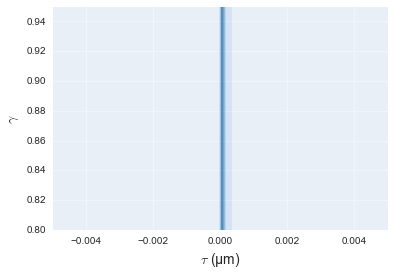

In [65]:
# Parameter values to plot
th = np.linspace(-0.005, 0.005, 100)
gamma = np.linspace(0.8, 0.95, 100)

# Make a grid
tt, gg = np.meshgrid(th, gamma)

# Compute log posterior
log_posterior = np.empty_like(tt)
for j in range(len(th)):
    for i in range(len(gamma)):
        log_posterior[i, j] = log_posterior_m1(np.array([tt[i,j], gg[i,j]]), df['12 uM'])
                            

# Get things to scale better
log_posterior -= log_posterior.max()
        
# Plot the results
plt.contourf(tt, gg, np.exp(log_posterior), cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel(r'$\tau$ (µm)')
plt.ylabel(r'$\gamma$');


In [36]:
def ecdf(data):
    """
    Compute `x` and `y` values for plotting an ECDF.
    
    Parameters
    ----------
    data : array_like
        Array of data to be plotted as an ECDF.
        
    Returns
    -------
    x : array
        `x` values for plotting
    y : array
        `y` values for plotting    
    """
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

In [37]:
def ecdf_conventional(data, buff=0.1, min_x=None, max_x=None):
    """
    Generate `x` and `y` values for plotting a conventional ECDF.
    
    Parameters
    ----------
    data : array_like
        Array of data to be plotted as an ECDF.
    buff : float, default 0.1
        How long the tails at y = 0 and y = 1 should extend as a fraction
        of the total range of the data.
    min_x : float, default -np.inf
        If min_x is greater than extent computed from `buff`, tail at
        y = 0 extends to min_x.
    max_x : float, default -np.inf
        If max_x is less than extent computed from `buff`, tail at
        y = 0 extends to max_x.

    Returns
    -------
    x : array
        `x` values for plotting
    y : array
        `y` values for plotting    
    """

    # Set defaults for min and max tails
    if min_x is None:
        min_x = -np.inf
    if max_x is None:
        max_x = np.inf
    
    # Get x and y values for data points
    x, y = ecdf(data)
    
    # Set up output arrays
    x_conv = np.empty(2*(len(x) + 1))
    y_conv = np.empty(2*(len(x) + 1))

    # y-values for steps
    y_conv[:2] = 0
    y_conv[2::2] = y
    y_conv[3::2] = y

    # x- values for steps
    x_conv[0] = max(min_x, x[0] - (x[-1] - x[0])*buff)
    x_conv[1] = x[0]
    x_conv[2::2] = x
    x_conv[3:-1:2] = x[1:]
    x_conv[-1] = min(max_x, x[-1] + (x[-1] - x[0])*buff)

    return x_conv, y_conv

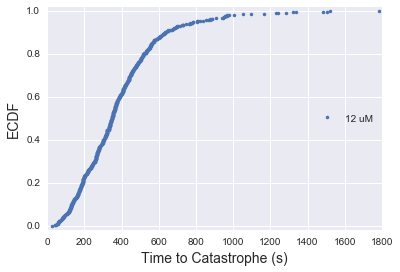

In [52]:
plt.plot(*ecdf(df_new1), marker='.', linestyle='none')
plt.margins(y=0.02)
plt.xlabel('Time to Catastrophe (s)')
plt.ylabel('ECDF')
plt.legend(('12 uM', ), loc='center right');

In [ ]:
def sample_ptmcmc(n, model, r_max=20, n_temps=20, n_walkers=50, n_burn=5000, 
                  n_steps=5000):
    """
    Sample posterior using PTMCMC.
    
    n = array of mRNA counts in cells
    """
    # Arguments for likelihood
    loglargs = (d,)
    
    # Arguments for prior
    logpargs = ()
    
    # Columns headings for outputted DataFrames
    columns = {1: ['tau'],
               2: ['tau', 'a'],
               3: ['tau', 'b']}
        
    # Parameters and how we start them
    if model == 1:
        # Build p0
        p0 = np.empty((n_temps, n_walkers, 2))
        p0[:,:,0] = np.random.uniform(0, tau_max, (n_temps, n_walkers))  # r

        # Get samples
        return bebi103.run_pt_emcee(
            log_likelihood_1, log_prior_1, n_burn, n_steps, n_temps=n_temps, 
            p0=p0, columns=columns[model], loglargs=loglargs, 
            logpargs=logpargs, return_lnZ=True)
    elif model == 2:
        # Build p0
        p0 = np.empty((n_temps, n_walkers, 5))
        p0[:,:,0] = np.random.uniform(0, tau_max, (n_temps, n_walkers))  # r1
        p0[:,:,1] = np.random.uniform(0, a_max, (n_temps, n_walkers))      # p1

        # Make sure p1 > p2
        p0[:,:,1], p0[:,:,3] = np.maximum(p0[:,:,1], p0[:,:,3]), \
                                np.minimum(p0[:,:,1], p0[:,:,3])
    
        return bebi103.run_pt_emcee(
            log_likelihood_2, log_prior_2, n_burn, n_steps,
            n_temps=n_temps, p0=p0, loglargs=loglargs, logpargs=logpargs, 
            columns=columns[model], return_lnZ=True)